In [1]:
from dotenv import load_dotenv
import os

# .env 파일에서 환경 변수 로드
load_dotenv()

# 환경 변수에서 PINECONE_API_KEY 가져오기
PINECONE_API_KEY = os.environ['PINECONE_API_KEY']
# PINECONE_API_KEY

# PINECONE 클라이언트 초기화

In [2]:
from pinecone import Pinecone, ServerlessSpec

pc = Pinecone(api_key=PINECONE_API_KEY)

# 레코드 Upsert

In [3]:
# embedding-3d 라는 이름의 인덱스 초기화
index = pc.Index("embedding-3d")

# 인덱스의 통계 정보에는 인덱스에 저장된 벡터의 수, 차원, 메타데이터 등의 정보가 포함
index.describe_index_stats()

{'dimension': 3,
 'index_fullness': 0.0,
 'namespaces': {},
 'total_vector_count': 0}

* namespaces가 비어있음
* namespaces에 이름이 없으면 hush가 없기 때문에 서칭 속도가 느려짐
* namespaces를 쓰면 속도 향상

# 벡터 임베딩

* id, values: 필수 field
* id: 키
* id, values 키는 반드시 문자열로 표현

벡터는 2차원, 근데 인덱스는 3차원임 -> 차원 다름

In [6]:
index.upsert(
    vectors=[       # 딕셔너리를 리스트로 넣음
        {
            "id": "vec1",
            # 원래 파인콘 홈페이지에서 복붙해오면 2차원임 
            # -> 3번째 숫자 임의로 추가해서 3차원 맞춰야함 (인덱스가 3차원이니까)                   
            "values": [1.0, 1.5, 2.0],       # 3차원 -> 유사도 계산할때 얘를 씀
            "metadata": {"genre": "drama"}   # 실제 데이터 
        }, {
            "id": "vec2", 
            "values": [2.0, 1.0, 0.5], 
            "metadata": {"genre": "action"}
        }, {
            "id": "vec3", 
            "values": [0.1, 0.3, 0.5], 
            "metadata": {"genre": "drama"}
        }, {
            "id": "vec4", 
            "values": [1.0, -2.5, 1.4], 
            "metadata": {"genre": "action"}
        }, {
            "id": "vec5",
            "values": [3.0, 1.2, 1.3],
            "metadata": {"genre": "action"}
        }, {
            "id": "vec6",
            "values": [0.3, 1.1, 2.5],
            "metadata": {"genre": "drama"}
        }
    ],
    namespace= "embedding-3d-ns1"  # namespace를 만들면 서칭 속도가 빨라짐
)

{'upserted_count': 6}

# 쿼리하기

* index.query() 메서드 사용
* 주어진 벡터와 유사한 상위 k개의 항목을 쿼리하여 응답을 반환함.
* namespace (str): 쿼리할 네임스페이스 이름
* vector (list): 쿼리에 사용할 벡터
* top_k (int): 반환할 상위 k개의 항목 수
* include_values (bool): 응답에 벡터 값을 포함할지 여부
* include_metadata (bool): 응답에 메타데이터를 포함할지 여부

In [8]:
# 유사도 높은 데이터 검색
response = index.query(
    namespace="embedding-3d-ns1",  # 네임 스페이스
     # namespace="",  
     # default, 기본 공간에서 찾음  , layer : 비슷한 것끼리 모아둠
    vector = [0.1, 0.3, 0.7],  # -> 쿼리 벡터
    top_k=3,                    # 유사도 높은 3개만 뽑
    include_values=True,        # value 포함
    include_metadata=True       # 메타데이터 포함
)

print(response)

{'matches': [{'id': 'vec6',
              'metadata': {'genre': 'drama'},
              'score': 0.998498499,
              'values': [0.3, 1.1, 2.5]},
             {'id': 'vec3',
              'metadata': {'genre': 'drama'},
              'score': 0.987675,
              'values': [0.1, 0.3, 0.5]},
             {'id': 'vec1',
              'metadata': {'genre': 'drama'},
              'score': 0.940560639,
              'values': [1.0, 1.5, 2.0]}],
 'namespace': 'embedding-3d-ns1',
 'usage': {'read_units': 6}}


* 주어진 벡터와 유사한 상위 k개의 항목을 필터 조건으로 쿼리하여 응답 반환

In [12]:
# 장르가 드라마인거 찾기 
# filter (딕셔너리): 쿼리할 벡터의 필터조건
response = index.query(
    namespace="embedding-3d-ns1",  # 네임 스페이스
    vector = [0.1, 0.3, 0.7],  # -> 쿼리 벡터
    top_k=3,                    # 유사도 높은 3개만 뽑
    include_values=True,        # value 포함
    include_metadata=True,       # 메타데이터 포함
    filter={                        # 필터: where절과 유사
        "genre":{"$eq":"drama"}     # 장르가 드라마인것만 필터링
    }
)

print(response)

{'matches': [{'id': 'vec6',
              'metadata': {'genre': 'drama'},
              'score': 0.998498499,
              'values': [0.3, 1.1, 2.5]},
             {'id': 'vec3',
              'metadata': {'genre': 'drama'},
              'score': 0.987675,
              'values': [0.1, 0.3, 0.5]},
             {'id': 'vec1',
              'metadata': {'genre': 'drama'},
              'score': 0.940560639,
              'values': [1.0, 1.5, 2.0]}],
 'namespace': 'embedding-3d-ns1',
 'usage': {'read_units': 6}}


* embedding-3d-ns1 네임스페이스의 모든 레코드 id 조회

In [13]:
for ids in index.list(namespace="embedding-3d-ns1"):
    print(ids)

['vec1', 'vec2', 'vec3', 'vec4', 'vec5', 'vec6']


* 지정된 네임스페이스(embedding-3d-ns1)에 있는 모든 ID를 리스트 형태로 반환

In [16]:
for ids in index.list(namespace="embedding-3d-ns1"):
    # vectors = index.fetch(ids, namespace="embedding-3d-ns1")
    # print(vectors)
    vectors = index.fetch(ids, namespace="embedding-3d-ns1")['vectors']
    print(vectors.values())

dict_values([{'id': 'vec3', 'metadata': {'genre': 'drama'}, 'values': [0.1, 0.3, 0.5]}, {'id': 'vec2', 'metadata': {'genre': 'action'}, 'values': [2.0, 1.0, 0.5]}, {'id': 'vec4', 'metadata': {'genre': 'action'}, 'values': [1.0, -2.5, 1.4]}, {'id': 'vec6', 'metadata': {'genre': 'drama'}, 'values': [0.3, 1.1, 2.5]}, {'id': 'vec1', 'metadata': {'genre': 'drama'}, 'values': [1.0, 1.5, 2.0]}, {'id': 'vec5', 'metadata': {'genre': 'action'}, 'values': [3.0, 1.2, 1.3]}])


* ids: 벡터 데이터에서 추출한 ID 리스트
* values: 벡터 데이터에서 추출한 값 리스트

In [18]:
ids = [v['id'] for v in vectors.values()] 
values = [v['values'] for v in vectors.values()] 

print(ids)
print(values)

['vec3', 'vec2', 'vec4', 'vec6', 'vec1', 'vec5']
[[0.1, 0.3, 0.5], [2.0, 1.0, 0.5], [1.0, -2.5, 1.4], [0.3, 1.1, 2.5], [1.0, 1.5, 2.0], [3.0, 1.2, 1.3]]


In [19]:
ids += ["qv"]
values += [[0.1, 0.3, 0.7]]

print(ids)
print(values)

['vec3', 'vec2', 'vec4', 'vec6', 'vec1', 'vec5', 'qv']
[[0.1, 0.3, 0.5], [2.0, 1.0, 0.5], [1.0, -2.5, 1.4], [0.3, 1.1, 2.5], [1.0, 1.5, 2.0], [3.0, 1.2, 1.3], [0.1, 0.3, 0.7]]


# Embedding Vector Space 시각화

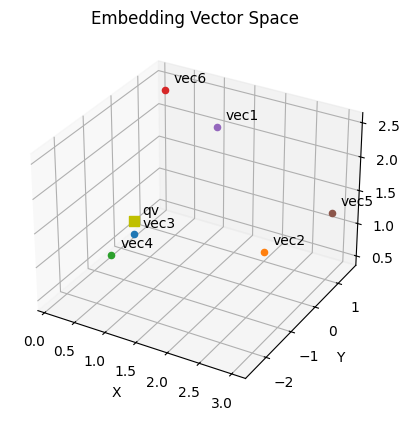

In [20]:
import matplotlib.pyplot as plt

# 3D 플롯을 생성
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 각 벡터의 ID, values -> 3D 공간에 점 그리기
for i, id in enumerate(ids):
    if id == "qv":
        # 쿼리 벡터는 노란색 사각형으로 표시
        ax.scatter(values[i][0], values[i][1], values[i][2], label=id, color='y', s=50, marker='s')
        ax.text(values[i][0] + 0.1, values[i][1] + 0.1, values[i][2] + 0.1, id)
    else:
        # 나머지 벡터는 기본 색상으로 표시합니다.
        ax.scatter(values[i][0], values[i][1], values[i][2], label=id)
        ax.text(values[i][0] + 0.1, values[i][1] + 0.1, values[i][2] + 0.1, id)

# 축 레이블과 제목을 설정합니다.
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Embedding Vector Space')

# 플롯을 표시합니다.
plt.show()

# 인덱스 생성 및 삭제

## 서버리스 인덱스 삭제

In [21]:
index_name = "quickstart"

# Pinecone에 있는 모든 인덱스 순회
for idx in pc.list_indexes():
    # 인덱스 이름이 quickstart와 일치하는 경우 해당 인덱스 삭제
    if idx.name == index_name:
        pc.delete_index(idx.name)

## 인덱스 생성

* Pinecone 인덱스 생성
* 인덱스 이름: "quickstart"
* 차원: 1024
* 메트릭: 코사인 유사도
* 인덱스는 AWS의 us-east-1 리전에서 서버리스 사양으로 생성

In [22]:
index_name = "quickstart"
pc.create_index(
    name=index_name,
    dimension=1024, # 모델 차원
    metric="cosine", # 모델 메트릭
    spec=ServerlessSpec(
        cloud="aws",
        region="us-east-1"
    )
)

In [23]:
# Pinecone 클라이언트를 사용하여 현재 사용 가능한 모든 인덱스의 목록을 반환합니다.
pc.list_indexes()

{'indexes': [{'deletion_protection': 'disabled',
              'dimension': 1024,
              'host': 'quickstart-4tog56e.svc.aped-4627-b74a.pinecone.io',
              'metric': 'cosine',
              'name': 'quickstart',
              'spec': {'serverless': {'cloud': 'aws', 'region': 'us-east-1'}},
              'status': {'ready': True, 'state': 'Ready'}},
             {'deletion_protection': 'disabled',
              'dimension': 3,
              'host': 'embedding-3d-4tog56e.svc.aped-4627-b74a.pinecone.io',
              'metric': 'cosine',
              'name': 'embedding-3d',
              'spec': {'serverless': {'cloud': 'aws', 'region': 'us-east-1'}},
              'status': {'ready': True, 'state': 'Ready'}}]}

# 임베딩 벡터 생성

Pinecone에서 레코드 id는 각 벡터를 고유하게 식별하는 데 사용됩니다.

Pinecone에서 id에 대한 주요 제약사항은 다음과 같습니다:

- 고유성: 각 벡터의 id는 인덱스 내에서 고유해야 합니다.
- 문자열 형식: id는 문자열 형태여야 합니다.
- 길이 제한: id의 최대 길이는 512바이트입니다.
- 허용 문자: id에는 영숫자, -, \_, #, :를 사용할 수 있습니다.
    - 각각의 특수 문자는 의미가 있음
- 대소문자 구분: id는 대소문자를 구분합니다.
- 공백 불가: id에는 공백을 포함할 수 없습니다

이러한 제약사항들은 Pinecone 시스템에서 벡터를 효율적으로 관리하고 검색할 수 있도록 하기 위해 설계되었습니다. id를 생성할 때 이러한 규칙을 준수하면 Pinecone 인덱스와 원활하게 작업할 수 있습니다.

In [24]:
data = [
    {"id": "vec1", "text": "사과는 달콤하고 아삭한 식감으로 유명한 인기 있는 과일입니다."},
    {"id": "vec2", "text": "애플이라는 기술 회사는 아이폰과 같은 혁신적인 제품으로 유명합니다."},
    {"id": "vec3", "text": "많은 사람들이 건강한 간식으로 사과를 즐겨 먹습니다."},
    {"id": "vec4", "text": "애플 주식회사는 세련된 디자인과 사용자 친화적인 인터페이스로 기술 산업을 혁신했습니다."},
    {"id": "vec5", "text": "하루에 사과 하나면 의사를 멀리할 수 있다는 속담이 있습니다."},
    {"id": "vec6", "text": "애플 컴퓨터 회사는 1976년 4월 1일 스티브 잡스, 스티브 워즈니악, 로널드 웨인에 의해 파트너십으로 설립되었습니다."}
]

In [25]:
embeddings = pc.inference.embed(
    model="multilingual-e5-large",
    inputs = [d['text'] for d in data],
    parameters = {"input_type": "passage", "truncate": "END"}
)

# 첫 번째 임베딩 벡터를 출력합니다
print(embeddings[0])

{'values': [0.0303497314453125, -0.02069091796875, ..., -0.0301971435546875, 0.0240325927734375]}


# 레코드 Upsert

In [26]:
import time

# 인덱스가 준비될 때까지 대기
while not pc.describe_index(index_name).status['ready']:
    time.sleep(1)

# 인덱스 초기화
index = pc.Index(index_name)

# 벡터 리스트를 초기화 & 벡터DB에 넣을 데이터셋 구성
vectors=[]
for d, e in zip(data, embeddings):
    # 각 데이터와 임베딩 결합 -> 벡터 생성
    vectors.append({
        "id":d['id'],
        "values": e["values"],
        "metadata":{'text':d['text']}
    })

# 벡터를 인덱스에 upsert
# quickstart_ns1 네임스페이스에 벡터를 추가
index.upsert(
    vectors=vectors,
    namespace="quickstart_ns1"
)

{'upserted_count': 6}

## 인덱스 통계 정보 확인

In [27]:
# Pinecone 인덱스 통계정보 설명 메서드 호출, 그 결과 출력
# 인덱스의 통계 정보에는 인덱스에 저장된 벡터의 수, 차원, 메타데이터 등의 정보가 포함

print(index.describe_index_stats(namespace="quickstart_ns1"))

{'dimension': 1024,
 'index_fullness': 0.0,
 'namespaces': {'quickstart_ns1': {'vector_count': 6}},
 'total_vector_count': 6}


## 쿼리 (Query)
* 쿼리 벡터 생성

In [28]:
# 쿼리 텍스트 정의
query = "애플이라는 기술 회사에 대해 알려주세요."

# 쿼리 텍스트를 임베딩 벡터로 변환합니다.
embedding = pc.inference.embed(
    model="multilingual-e5-large", # ms 오픈 소스, 1024 차원
    inputs=[query],
    parameters={
        "input_type":"query" # 입력 타입을 쿼리로 설정
    }
)

print(embedding[0])

{'values': [0.01128387451171875, -0.017608642578125, ..., -0.02032470703125, -0.006984710693359375]}


# 유사 벡터 검색 쿼리 실행
* ns1 네임스페이스에서 쿼리 벡터와 유사한 상위 3개의 벡터 검색

In [29]:
# 검색 결과 -> 벡터 값 포함 X, 메타데이터만 포함
results = index.query(
    namespace="quickstart_ns1",
    vector=embedding[0].values, # query 벡터
    top_k=3,
    include_values=False,  # value는 제외
    include_metadata=True
)

# 검색 결과를 출력
print(results)

{'matches': [{'id': 'vec2',
              'metadata': {'text': '애플이라는 기술 회사는 아이폰과 같은 혁신적인 제품으로 유명합니다.'},
              'score': 0.896025717,
              'values': []},
             {'id': 'vec4',
              'metadata': {'text': '애플 주식회사는 세련된 디자인과 사용자 친화적인 인터페이스로 기술 산업을 '
                                   '혁신했습니다.'},
              'score': 0.883902133,
              'values': []},
             {'id': 'vec6',
              'metadata': {'text': '애플 컴퓨터 회사는 1976년 4월 1일 스티브 잡스, 스티브 워즈니악, '
                                   '로널드 웨인에 의해 파트너십으로 설립되었습니다.'},
              'score': 0.867603183,
              'values': []}],
 'namespace': 'quickstart_ns1',
 'usage': {'read_units': 6}}


* 쿼리 텍스트 정의 → 임베딩 벡터로 변환 → 임베딩 벡터 출력

In [30]:
# 쿼리 텍스트 정의
query="애플(사과)라는 기술 회사에 대해 알려주세요."

# 쿼리 텍스트를 임베딩 벡터로 변환
embedding=pc.inference.embed(
    model="multilingual-e5-large",
    inputs=[query],
    parameters={
        "input_type": "query"  # 입력 타입을 쿼리로 설정
    }
)

# 첫 번째 임베딩 벡터를 출력
print(embedding[0])

{'values': [-0.00437164306640625, -0.021728515625, ..., -0.01873779296875, 0.00787353515625]}
